# 1. Import Libraries and Load Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.preprocessing import StandardScaler, PowerTransformer#, LabelEncoder, OneHotEncoder

The dataset contains details of customers for a given bank. Features include demographics, income, and product engagement measures. There are a total of 10K observations, spanning 14 columns. The target variable is 'Exited' which identifies if a person is no longer a bank customer.

In [2]:
df = pd.read_csv(r"data/archive/Churn_Modelling.csv")
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


# 2. Check Dataset for Missing Values and Column Data Types

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### 2a. Remove Identifier columns

In [4]:
cols_to_remove = ['RowNumber', #row identifier
                 'CustomerId', #unique customer identifier
                 'Surname' #unique customer identifier
                 ]

df = df.drop(columns=cols_to_remove)

### 2b. Checking Target Variable

In [5]:
#Identify target column cardinality.
print(f"The target values are: {df['Exited'].unique()}\n")

print(f"The counts of each target is:\n{df['Exited'].value_counts()}")

The target values are: [1 0]

The counts of each target is:
0    7963
1    2037
Name: Exited, dtype: int64


### 2c. Encode Categorical Features
To enconde categorical variables we'll employ Pandas' get_dummies()

In [6]:
cols_to_enc = ['Geography', 'Gender']
df = pd.get_dummies(df, columns=cols_to_enc)

### 2d. Scale and Transform Numerical Variables

In [7]:
#define numeric columns to be scaled
numeric_columns = ['CreditScore',
                   'Age',
                   'Tenure',
                   'Balance',
                   'NumOfProducts',
                   'EstimatedSalary']

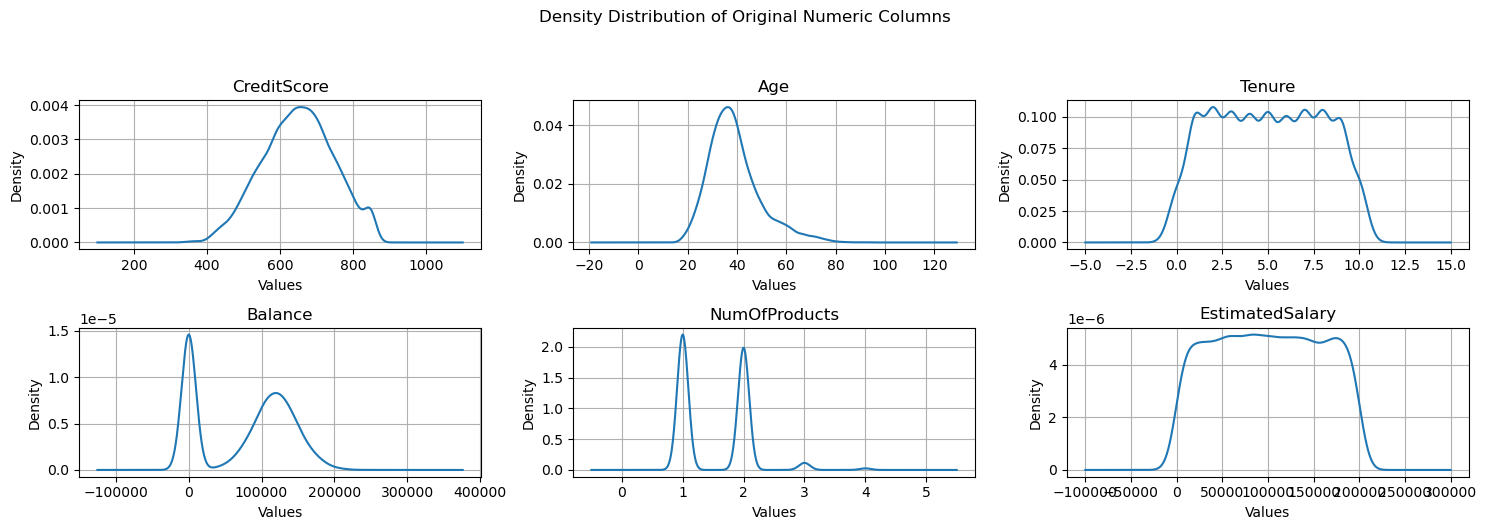

In [8]:
fig1, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
fig1.suptitle('Density Distribution of Original Numeric Columns', y=1.05)

for i, column in enumerate(numeric_columns):
    ax=axes[i//3, i%3]
    df[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [9]:
#### Scale Data
scaler = StandardScaler()

df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [10]:
#Power Transform numeric values
transformer = PowerTransformer(method='yeo-johnson', standardize=True)

df[numeric_columns] = transformer.fit_transform(df[numeric_columns])
df[numeric_columns] = transformer.transform(df[numeric_columns])

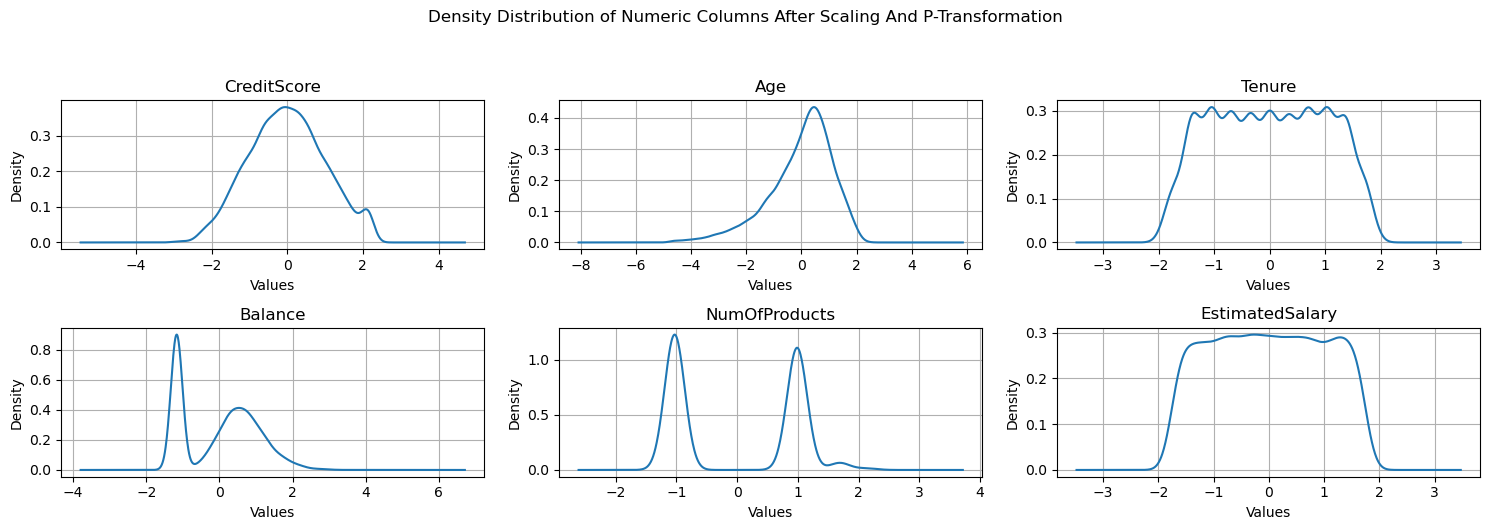

In [11]:
fig2, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
fig2.suptitle('Density Distribution of Numeric Columns After Scaling And P-Transformation', y=1.05)

for i, column in enumerate(numeric_columns):
    ax=axes[i//3, i%3]
    df[column].plot(kind='kde', ax=ax)
    ax.set_title(column)
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.grid(True)

plt.tight_layout()
plt.show()

# 3. Fixing Class Imbalance  
In the previous model, SMOTE performed better than undersampling. As such, SMOTE will be used to build the SVC model.

In [12]:
#Separate Features and Target Variable
X_sm = df.drop(['Exited'], axis=1)
y_sm = df['Exited']

#Split data into Train and Test Sets
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.25, random_state=40)

#Execute SMOTE
sm = SMOTE(random_state=40)
X_train_sm, y_train_sm = sm.fit_resample(X_train_sm, y_train_sm)
print("Resampled dataset shape %s" % Counter(y_train_sm))

Resampled dataset shape Counter({0: 5952, 1: 5952})


# 4. Initialize GPU Framework

In [13]:
!nvidia-smi

Wed May 15 00:33:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   28C    P8              24W / 420W |    504MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
#load gpu libraries
import cudf
import cuml
import cupy as cp

#import dask_ml.model_selection as dcv
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

import cuml.svm
from cuml.svm import LinearSVC, SVC
#from dask_ml.metrics import accuracy_score
from cuml.metrics.accuracy import accuracy_score
#from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import dask_cudf

In [15]:
#Clear GPU memory
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

0

In [16]:
#Spin Up GPU Cluster
#3090: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4
#2060S: GPU-9234d598-4065-602a-8139-1b0b2bc70750

cluster = LocalCUDACluster(protocol="ucx", #use ucx for inter-gpu training (RDMA, exclude cpu)
                           enable_tcp_over_ucx=None,
                           CUDA_VISIBLE_DEVICES= "0") #sets first gpu as a worker (In this case: 3090)
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 39.03 GiB
Status: running,Using processes: True
Comm: ucx://127.0.0.1:40161,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 39.03 GiB
Comm: ucx://127.0.0.1:54773,Total threads: 1
Dashboard: http://127.0.0.1:36501/status,Memory: 39.03 GiB
Nanny: ucx://127.0.0.1:45549,


##### Convert Data to cuDF

In [17]:
X_train_gpu = cudf.DataFrame.from_pandas(X_train_sm)
X_test_gpu = cudf.DataFrame.from_pandas(X_test_sm)
y_train_gpu = cudf.Series.from_pandas(y_train_sm)
y_test_gpu = cudf.Series.from_pandas(y_test_sm)

seed = 40

# 5. Train SVM Model

In [18]:
# %%time

# params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
#               'probability': [True, False],
#               'degree': [3, 5, 7, 10],
#               'kernel': ['linear', 'rbf', 'sigmoid']
#              }

# def update_best_model(accuracy, C, gamma, probability, degree, kernel):
#     ''' Updates dictionary with the best parameters based on accuracy'''
#     global best_accuracy, best_params
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_params = {'C': C, 'gamma': gamma, 'degree': degree, 'probability': probability, 'kernel': kernel}

# # Total iterations for progress bar
# from tqdm import tqdm
# total_iterations = sum([
#     len(params['C']) * len(params['gamma']) * (len(params['degree']) if kernel == 'poly' else 1) * 2
#     for kernel in params['kernel'] if kernel != 'linear'
# ]) + len(params['C']) * 2  # Only C and probability matter for linear kernel

# progress_bar = tqdm(total=total_iterations, desc="Grid Search Progress")

# best_accuracy = 0
# best_params = {}

# for kernel in params['kernel']:
#     for C in params['C']:
#         if kernel in ['rbf', 'poly', 'sigmoid']:
#             for gamma in params['gamma']:
#                 if kernel == 'poly':
#                     print("Working on poly")
#                     for degree in params['degree']:
#                         for probability in [True, False]:
#                             # Initialize model with parameters relevant to 'poly' kernel
#                             model = cuml.SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, probability=probability)
#                             model.fit(X_train_gpu, y_train_gpu)
#                             predictions = model.predict(X_test_gpu)
#                             accuracy = accuracy_score(y_test_gpu, predictions)
#                             update_best_model(accuracy, C, gamma, probability, degree, kernel)
#                             progress_bar.update(1)
#                 else:
#                     for probability in [True, False]:
#                         # Initialize model for 'rbf' and 'sigmoid' with their relevant parameters
#                         model = cuml.SVC(C=C, kernel=kernel, gamma=gamma, probability=probability)
#                         model.fit(X_train_gpu, y_train_gpu)
#                         predictions = model.predict(X_test_gpu)
#                         accuracy = accuracy_score(y_test_gpu, predictions)
#                         update_best_model(accuracy, C, gamma, probability, None, kernel)
#                         progress_bar.update(1)
#         else:
#             # Handle 'linear' kernel which does not use 'gamma' or 'degree'
#             print("Working on linear")
#             for probability in [True, False]:
#                 model = cuml.SVC(C=C, kernel=kernel, probability=probability)
#                 model.fit(X_train_gpu, y_train_gpu)
#                 predictions = model.predict(X_test_gpu)
#                 accuracy = accuracy_score(y_test_gpu, predictions)
#                 update_best_model(accuracy, C, None, probability, None, kernel)
#                 progress_bar.update(1)

# progress_bar.close()
# print("Best Accuracy:", best_accuracy)
# print("Best Parameters:", best_params)

In [23]:
%%time

params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

best_accuracy = 0
best_params = None

kf = KFold(n_splits=5, shuffle=True, random_state=seed)
progress_bar = tqdm(total=len(params['C']) * len(params['gamma']) * len(params['kernel']) * 5, desc="Grid Search Progress")

for kernel in params['kernel']:
    for C in params['C']:
        for gamma in params['gamma']:
            fold_accuracies = []
            for train_index, test_index in kf.split(X_train_gpu):
                X_train_fold = X_train_gpu.iloc[train_index]
                y_train_fold = y_train_gpu.iloc[train_index]
                X_test_fold = X_train_gpu.iloc[test_index]
                y_test_fold = y_train_gpu.iloc[test_index]


                model = SVC(C=C, kernel=kernel, gamma=gamma)
                model.fit(X_train_fold, y_train_fold)

                predictions = model.predict(X_test_fold)
                
                # Convert cuDF or cuPy arrays to numpy arrays before scoring
                accuracy = accuracy_score(y_test_fold.to_numpy(), predictions.to_numpy())
                fold_accuracies.append(accuracy)

            average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
            if average_accuracy > best_accuracy:
                best_accuracy = average_accuracy
                best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}

            progress_bar.update(1)

progress_bar.close()
print("Best Accuracy:", best_accuracy)
print("Best Parameters:", best_params)


Grid Search Progress:   2%|▎                   | 12/720 [00:40<40:18,  3.42s/it]

Grid Search Progress:  20%|███▍             | 144/720 [41:24<2:45:36, 17.25s/it]

Best Accuracy: 0.9077614068984985
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
CPU times: user 41min 36s, sys: 13.2 s, total: 41min 49s
Wall time: 41min 24s


# Train Official Model with Optimal Parameters

In [23]:
%%time

#Initialize model
model = SVC(C=10, kernel='rbf', gamma=1, probability=True)

#create folds
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_train_gpu):
                X_train_fold = X_train_gpu.iloc[train_index]
                y_train_fold = y_train_gpu.iloc[train_index]
                X_test_fold = X_train_gpu.iloc[test_index]
                y_test_fold = y_train_gpu.iloc[test_index]

#Fit model
model.fit(X_train_fold, y_train_fold)
y_pred = model.predict(X_test_fold)

#Get Accuracies
fold_accuracies = []
accuracy = accuracy_score(y_test_fold.to_numpy(), y_pred.to_numpy())
fold_accuracies.append(accuracy)
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)

print(average_accuracy)

0.8999999761581421
CPU times: user 2.22 s, sys: 93 ms, total: 2.31 s
Wall time: 2.26 s


# Evaluate Official Model

In [30]:
#Calculate metrics
accuracy = accuracy_score(y_test_fold.to_pandas(), y_pred.to_pandas())
precision = precision_score(y_test_fold.to_pandas(), y_pred.to_pandas(), average='macro')
recall = recall_score(y_test_fold.to_pandas(), y_pred.to_pandas(), average='macro')
f1 = f1_score(y_test_fold.to_pandas(), y_pred.to_pandas(), average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8999999761581421
Precision: 0.8999866466106766
Recall: 0.8999301342002627
F1 Score: 0.8999558452109715


### Confusion Matrix

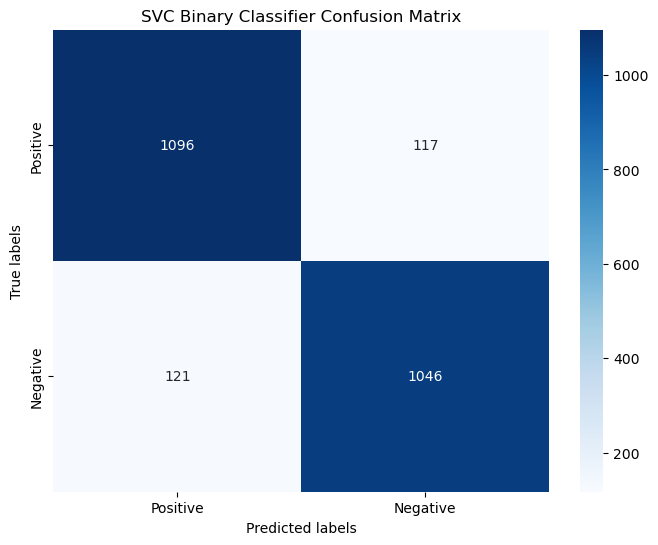

In [32]:
# Create confusion matrix
cm = confusion_matrix(y_test_fold.to_pandas(), y_pred.to_pandas())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('SVC Binary Classifier Confusion Matrix')
#plt.savefig('../../Graphs/Conf_Mat/KNN_HPO_CM_nneighbors71.png')
plt.show()

### ROC Curve

In [33]:
y_probs = model.predict_proba(X_test_fold.to_pandas())
y_probs

,0,1
0,0.978118,0.021882
1,0.890979,0.109021
2,0.264336,0.735664
3,0.980111,0.019889
4,0.931254,0.068746
...,...,...
2375,0.050877,0.949123
2376,0.032259,0.967741
2377,0.110188,0.889812
2378,0.028303,0.971697


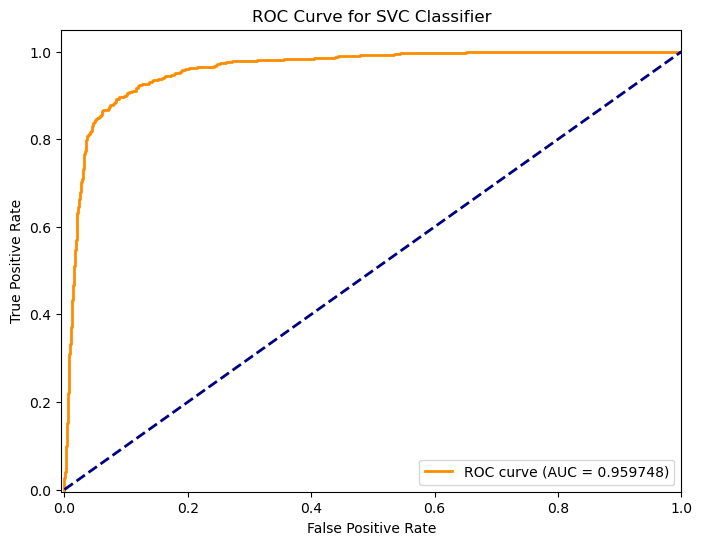

In [35]:
#Calculate prediction performance metrics
fpr, tpr, thresholds = roc_curve(y_test_fold.to_pandas(), y_probs[1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC Classifier')
plt.legend(loc="lower right")
#plt.savefig('../../Graphs/ROC_CUR/KNN_HPO_ROC_nneighbors71.png')
plt.show()

# Saving Trained Model

In [37]:
# Save the trained model using pickle
import pickle
model_filename = 'cuSVC_model_HPO.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

# Discussion & Findings

   The article _A novel approach to predict COVID-19 using support vector machine_ by Amir Ahmamad, et al., as well as _Decision Tree Ensembles to Predict Coronavirus Disease 2019 Infection: A Comparative Study_ by Soham Guhathakurata, et al., are prime examples of the importance of understanding the underlying data. Not all data is created equal, and as such, certain combinations of algorithms, preprocessing techniques, and feature selection can alter predictive performance.  
  
   Amir Ahmamad, et al., highlight the importance of identifying class imbalance and exploring algorithms designed to handle it. Moreover, they discuss the importance of identifying the most predictive features, which sometimes can be omitted or are latent features. In their study, they found that the variable 'Age' plays an important role because it is correlated with the severity or appearance of other COVID-19 symptoms (features).  
Soham Guhathakurata, et al., also discussed in their study the importance of the nature of the problem. For instance, the _not infected_ class is not 100% certain that they are not infected by the virus. This is reflected in the F1-scores reported for each class, where the _not infected_ class has the lowest score, whereas the severely infected class has the highest. Overall, their study concluded that SVM can be applied to deduce a patient's condition with an overall accuracy score of 87%.  
   
   In the study _Model of Customer Churn Prediction on Support Vector Machine_ by Xia Guo-en and Jin Wei-dong (2008), SVM is explored as a tool to predict customer churn for a telecommunications company, which are known to have a high customer churn rates. They compared their findings to an artificial neural network, a decision tree, logistic regression, and a naive Bayes classifier. SVM beat performance scores against all other algorithms in every single metric. They attributed the overall performance to the ability of SVM to infer from the data condition and structure; in other words, the ability to classify in a non-linear space. SVM scored 90.88% in accuracy, whereas Decision Tree C4.5 scored 83.86%. In conclusion, it is highlighted that telecommunications customer churn data is very similar to bank customer churn data, hinting at the possibility of employing similar techniques for financial institutions.

In _MACHINE LEARNING BASED CUSTOMER CHURN PREDICTION IN BANKING_ by Manas Rahman and V. Kumar, it was found that Random Forest and Decision Trees performed better than Support Vector Machine. However, the linear kernel function was used, implying that the model was unable to fit to the data to its full potential. After feature selection, the accuracy score for SVM was 69.96%, whereas DT and RF scored 91.73% and 92.95%, respectively. This study also concluded that employing oversampling increased scores for DT and RF.  
  
  In 2018, Sahar F. Sabbeh released the study Machine-Learning Techniques for Customer Retention: A Comparative Study, where customer retention prediction was explored by looking at many different types of machine learning algorithms. Random Forest performed best with an accuracy score of 98%, followed by SVM with a 94% score, and a decision tree with a 90% score. In particular, RF was employed with mean decrease measures to assign weights to each feature. The data used is not the same as that of other financial institutions, but it is similar in other aspects such as customer activity.  
  
  In my previous tree-based models, RF performed best with a 76% accuracy score. By employing SVC in-tandem with a radial basis function, an accuracy score of 90% was achieved. Like the aforementioned studies, this spike in performance can be attributed to employing SMOTE to fix class imbalance, and the use of the kernel trick to better divide the spatial structure of the classes. In this specific problem (and dataset), we are concerned with predicting customer churn, as a result, SVM triumphs over the tree-based methods and should be preferred. Higher prediction accuracy is more important than interpretability as this is what would lead financial institutions to implement strategic customer retention roll-outs. Next steps in this study would be to implement feature selection methods, and possibly the mean decrease accuracy for random forest.